In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from deepctr.feature_column import SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names
from deepctr.models import DeepFM

In [2]:
data = pd.read_csv("../data/recipe/merged_data.csv")

In [3]:
data.head(3)

,user_id,recipe_id,rating,name,minutes,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,38094,40893,4,white bean green chile pepper soup,495,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9
1,1293707,40893,5,white bean green chile pepper soup,495,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9
2,8937,44394,4,devilicious cookie cake delights,20,"['30-minutes-or-less', 'time-to-make', 'course...","[132.3, 11.0, 39.0, 5.0, 4.0, 11.0, 5.0]",5,"['blend together cake mix , oil and eggs', 'ad...",NaN,"[""devil's food cake mix"", 'vegetable oil', 'eg...",4


In [4]:
data.shape

(1132366, 12)

In [5]:
data = data[data['rating'] != 0]

In [6]:
data.isna().sum()

user_id              0
recipe_id            0
rating               0
name                 0
minutes              0
tags                 0
nutrition            0
n_steps              0
steps                0
description      22366
ingredients          0
n_ingredients        0
dtype: int64

In [7]:
data.dropna(inplace=True)

In [8]:
data.drop(['steps'], axis=1, inplace=True)

In [9]:
data.shape

(1049154, 11)

### Reducing data for memory consumption

In [10]:
# Get unique recipe IDs
recipe_ids = data['recipe_id'].unique()

# Define the percentage of recipes to remove
percentage_to_remove = 0.7

# Calculate the number of recipes to remove
num_recipes_to_remove = int(len(recipe_ids) * percentage_to_remove)

# Randomly select recipes to remove
recipes_to_remove = np.random.choice(recipe_ids, num_recipes_to_remove, replace=False)

# Remove rows with selected recipe IDs
data = data[~data['recipe_id'].isin(recipes_to_remove)]

In [11]:
sparse_features = ['user_id', 'recipe_id', 'description']
dense_features = ['minutes', 'n_steps', 'n_ingredients']
varlen_features = ['tags', 'nutrition', 'ingredients']

In [12]:
data[sparse_features] = data[sparse_features].astype(str)

In [13]:
# Do simple Transformation for dense features
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [27]:
def pad_varlen(varlen_list, max_len=None):
    if not max_len:
        length = np.array([len(item) for item in varlen_list]) 
        max_len = max(length)
    return (max_len, pad_sequences(varlen_list, maxlen=max_len, padding='post', dtype=object, value=0).astype(str))

In [15]:
import ast

def convert_to_list(string):
    return ast.literal_eval(string)

for feature in varlen_features:
    data[feature] = data[feature].apply(convert_to_list)

In [16]:
train, test = train_test_split(data, test_size=0.2)

In [17]:
(tm, tags_train) = pad_varlen(train['tags'])
(nm, nutrition_train) = pad_varlen(train['nutrition'])
(im, ingredients_train) = pad_varlen(train['ingredients'])

In [28]:
(_, tags_test) = pad_varlen(test['tags'], tm)
(_, nutrition_test) = pad_varlen(test['nutrition'], nm)
(_, ingredients_test) = pad_varlen(test['ingredients'], im)

In [19]:
max_length = [tm, nm, im]

In [20]:
# Set hashing space for each sparse field and generate feature config for sequence feature
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique() * 5, embedding_dim=4, use_hash=True, dtype='string')
                            for feat in sparse_features]

dense_feature_columns = [DenseFeat(feat, 1, ) for feat in dense_features]

varlen_feature_columns = [
    VarLenSparseFeat(SparseFeat(feat, vocabulary_size=100, embedding_dim=4, use_hash=True, dtype="string"),
                        maxlen=max_len, combiner='mean', )
                        for max_len, feat in zip(max_length, varlen_features)]

linear_feature_columns = fixlen_feature_columns + dense_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + dense_feature_columns + varlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [21]:
feature_names

['user_id',
 'recipe_id',
 'description',
 'minutes',
 'n_steps',
 'n_ingredients',
 'tags',
 'nutrition',
 'ingredients']

In [22]:
# Generate input data for model
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

train_model_input['tags'] = tags_train
train_model_input['nutrition'] = nutrition_train
train_model_input['ingredients'] = ingredients_train

In [29]:
test_model_input['tags'] = tags_test
test_model_input['nutrition'] = nutrition_test
test_model_input['ingredients'] = ingredients_test

In [24]:
# Define Model,compile and train
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')

model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(train_model_input, train['rating'].values,
                    batch_size=256, epochs=20, verbose=2, validation_split=0.2, )

Epoch 1/20
775/775 - 115s - loss: 1.0987 - mse: 1.0976 - val_loss: 0.4850 - val_mse: 0.4823
Epoch 2/20
775/775 - 108s - loss: 0.3674 - mse: 0.3631 - val_loss: 0.5125 - val_mse: 0.5066
Epoch 3/20
775/775 - 117s - loss: 0.2631 - mse: 0.2562 - val_loss: 0.5558 - val_mse: 0.5478
Epoch 4/20
775/775 - 109s - loss: 0.2136 - mse: 0.2049 - val_loss: 0.5856 - val_mse: 0.5760
Epoch 5/20
775/775 - 116s - loss: 0.1811 - mse: 0.1711 - val_loss: 0.6134 - val_mse: 0.6027
Epoch 6/20
775/775 - 109s - loss: 0.1618 - mse: 0.1508 - val_loss: 0.6048 - val_mse: 0.5932
Epoch 7/20
775/775 - 104s - loss: 0.1452 - mse: 0.1335 - val_loss: 0.6328 - val_mse: 0.6207
Epoch 8/20
775/775 - 110s - loss: 0.1336 - mse: 0.1215 - val_loss: 0.6419 - val_mse: 0.6293
Epoch 9/20
775/775 - 118s - loss: 0.1246 - mse: 0.1120 - val_loss: 0.6559 - val_mse: 0.6429
Epoch 10/20
775/775 - 110s - loss: 0.1170 - mse: 0.1040 - val_loss: 0.6490 - val_mse: 0.6357
Epoch 11/20
775/775 - 108s - loss: 0.1095 - mse: 0.0962 - val_loss: 0.6380 - va

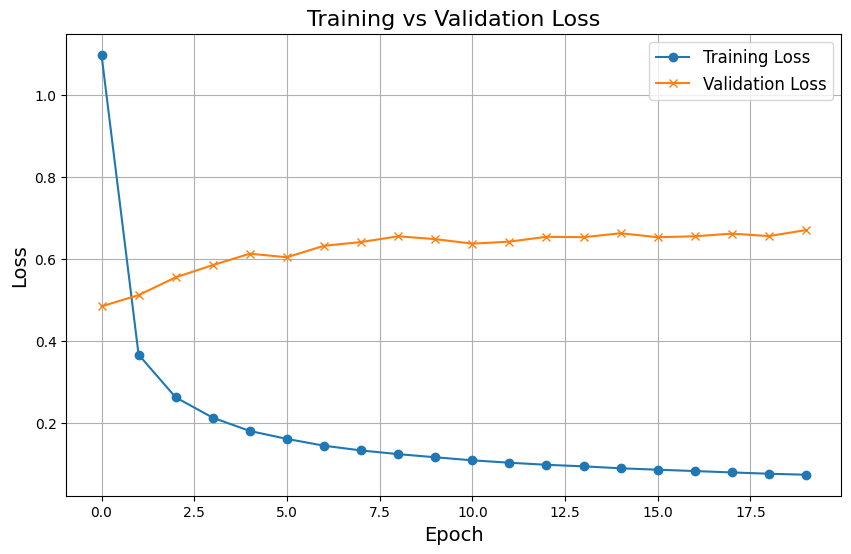

In [25]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='x')

plt.title("Training vs Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

In [35]:
# Predict
pred_ans = model.predict(test_model_input, batch_size=256)

In [37]:
# Evaluate Model
mse_value = mean_squared_error(test['rating'].values, pred_ans)
print("Test MSE:", round(mse_value, 4))

Test MSE: 0.641
